In [1]:
import os
TITANIC_PATH = os.path.join("C:\\Users\\barak\\Documents\\GitHub\\\Kaggle_Titanic_Competition","Dataset")

In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [4]:
y = train_data.Survived
X = train_data.drop(['Survived'],axis=1)

from sklearn.model_selection import train_test_split
X_train, X_val , y_train, y_val= train_test_split(X,y,test_size=0.20)


In [5]:
len(X)

891

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
# To szybka klasa która robi i zamienia dane kategoryczne na numeryczne
# Zamieniamy na dane numeryczne ABC i jeśli chcemy zamienic na numeryczne to bierzemy one hot encode

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#Imputer wypełnia dane na odstawie tej Strategoo
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age",'Pclass',])),
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(strategy="median")),
    ])


In [8]:

num_pipeline.fit_transform(X_train)

array([[-0.09469253, -1.58243582],
       [-0.50564033,  0.80969646],
       [-0.09469253,  0.80969646],
       ...,
       [-0.09469253, -1.58243582],
       [-1.01932508,  0.80969646],
       [-0.09469253,  0.80969646]])

In [9]:
# Inspired from stackoverflow.com/questions/25239958

# Szybka klasa która wylicza najczęściej występujacy element itp
# 
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [10]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(['Embarked','Name','Sex','Ticket','Cabin'])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])



In [11]:
cat_pipeline.fit_transform(X_train)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [12]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

#Mamy tutaj Feature Union którea łączy nasze cechy  i pipelien'y
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [13]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5)

In [14]:
# SVC predictors

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

pipe_1 = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='rbf'))])
pipe_2 = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='poly'))])
pipe_3 = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='linear'))])
pipe_4 = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', LogisticRegression())])

param_grid = {
            'classifier__gamma': [0.001,0.003, 0.01,0.03, 0.1,0.3, 1, 10, 100,200],
            'classifier__C': [0.001,0.003, 0.01, 0.03, 0.1,0.3, 1, 10, 100,200]
}
param_grid_2 = {
            'classifier__C': [0.001, 0.01 ,0.03, 0.1,0.3, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe_1, param_grid, cv=kfold)
grid_2 = GridSearchCV(pipe_2, param_grid, cv=kfold)
grid_3 = GridSearchCV(pipe_3, param_grid, cv=kfold)
grid_4 = GridSearchCV(pipe_4, param_grid_2, cv=kfold)

grid_1.fit(X_train, y_train)
grid_2.fit(X_train, y_train)
grid_3.fit(X_train, y_train)
grid_4.fit(X_train, y_train)



C:\Users\barak\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\barak\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        FeatureUnion(transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('select_numeric',
                                                                                         DataFrameSelector(attribute_names=['Age',
                                                                                                                            'Pclass'])),
                                                                                        ('scaler',
                                                                                         StandardScaler()),
                                                                                        ('imputer',
                                                                                         Simpl

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

preds = [(grid_1.best_estimator_,'SVC_rbf'),(grid_2.best_estimator_,'SVC_poly'),(grid_3.best_estimator_,'SVC_rbf'),(grid_4.best_estimator_,'LogReg')]

for clf,name in preds:
    clf.fit(X_val, y_val)
    y_pred = clf.predict(X_val)
    print(name, accuracy_score(y_val, y_pred))


SVC_rbf 1.0
SVC_poly 1.0
SVC_rbf 1.0
LogReg 1.0


In [16]:
prediction_1 = grid_1.best_estimator_.predict(test_data)
prediction_2= grid_2.best_estimator_.predict(test_data)
prediction_3= grid_3.best_estimator_.predict(test_data)
prediction_4= grid_4.best_estimator_.predict(test_data)

In [17]:
import numpy as np

data=np.vstack([prediction_1,prediction_2,prediction_3,prediction_4]).T
prediction_1 = np.vstack([np.arange(len(X_train)+1,len(X_train)+len(prediction_1)+1,1),prediction_1]).T
prediction_2 = np.vstack([np.arange(len(X_train)+1,len(X_train)+len(prediction_1)+1,1),prediction_2]).T
prediction_3 = np.vstack([np.arange(len(X_train)+1,len(X_train)+len(prediction_1)+1,1),prediction_3]).T
prediction_4 = np.vstack([np.arange(len(X_train)+1,len(X_train)+len(prediction_1)+1,1),prediction_4]).T
df_prediction_1 = pd.DataFrame(prediction_1,columns=['PassengerId','Survived'])
df_prediction_2 = pd.DataFrame(prediction_2,columns=['PassengerId','Survived'])
df_prediction_3 = pd.DataFrame(prediction_3,columns=['PassengerId','Survived'])
df_prediction_4 = pd.DataFrame(prediction_4,columns=['PassengerId','Survived'])


df_prediction_1.to_csv(os.path.join("C:\\Users\\barak\\Documents\\GitHub\\\Kaggle_Titanic_Competition\\Results",'SVC_rbf.csv'),index=False) # BEST ONE SO FAR
df_prediction_2.to_csv(os.path.join("C:\\Users\\barak\\Documents\\GitHub\\\Kaggle_Titanic_Competition\\Results",'SVC_poly.csv'),index=False)
df_prediction_3.to_csv(os.path.join("C:\\Users\\barak\\Documents\\GitHub\\\Kaggle_Titanic_Competition\\Results",'SVC_lin.csv'),index=False)
df_prediction_4.to_csv(os.path.join("C:\\Users\\barak\\Documents\\GitHub\\\Kaggle_Titanic_Competition\\Results",'LogReg.csv'),index=False)


Best one:  **SVM**:
+ kernel: rbf
+ C = 100
+ gamma = 0.01
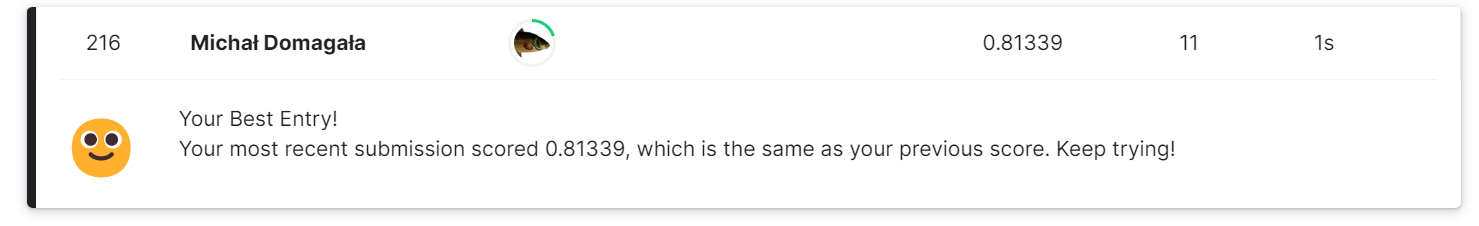

In [18]:
grid_1.best_estimator_

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('num_pipeline',
                                                 Pipeline(steps=[('select_numeric',
                                                                  DataFrameSelector(attribute_names=['Age',
                                                                                                     'Pclass'])),
                                                                 ('scaler',
                                                                  StandardScaler()),
                                                                 ('imputer',
                                                                  SimpleImputer(strategy='median'))])),
                                                ('cat_pipeline',
                                                 Pipeline(steps=[('select_cat',
                                                                  DataFrameSelector(attribute_names=['Embark

In [19]:
X_val

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
711,712,1,"Klaber, Mr. Herman",male,NaN,0,0,113028,26.5500,C124,S
32,33,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
661,662,3,"Badt, Mr. Mohamed",male,40.0,0,0,2623,7.2250,NaN,C
269,270,1,"Bissette, Miss. Amelia",female,35.0,0,0,PC 17760,135.6333,C99,S
286,287,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
608,609,2,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",female,22.0,1,2,SC/Paris 2123,41.5792,NaN,C
637,638,2,"Collyer, Mr. Harvey",male,31.0,1,1,C.A. 31921,26.2500,NaN,S
631,632,3,"Lundahl, Mr. Johan Svensson",male,51.0,0,0,347743,7.0542,NaN,S
34,35,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C


In [20]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
55,56,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
376,377,3,"Landergren, Miss. Aurora Adelia",female,22.0,0,0,C 7077,7.2500,NaN,S
355,356,3,"Vanden Steen, Mr. Leo Peter",male,28.0,0,0,345783,9.5000,NaN,S
307,308,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,1,0,PC 17758,108.9000,C65,C
319,320,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.5000,E34,C
...,...,...,...,...,...,...,...,...,...,...,...
416,417,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,34.0,1,1,28220,32.5000,NaN,S
556,557,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C
457,458,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D21,S
111,112,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C


In [21]:
X_val = preprocess_pipeline.transform(X_val)
X_train = preprocess_pipeline.transform(X_train)

In [22]:
X_val = pd.DataFrame(X_val)
X_train = pd.DataFrame(X_train)

In [23]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407
0,-0.094693,-1.582436,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.505640,0.809696,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.094693,0.809696,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.848097,-1.582436,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.727203,-1.582436,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.316255,-0.386370,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
708,1.275133,-1.582436,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
709,-0.094693,-1.582436,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
710,-1.019325,0.809696,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
X_val

,0,1,2,3,4,5,6,7,8,9,...,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407
0,-0.094693,-1.582436,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.094693,0.809696,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.727203,0.809696,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.384747,-1.582436,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.042290,0.809696,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,-0.505640,-0.386370,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
175,0.110781,-0.386370,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
176,1.480607,0.809696,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
177,-0.094693,-1.582436,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Deep Learning

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 4000)              5636000   
                                                                 
 batch_normalization_17 (Bat  (None, 4000)             16000     
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 2000)              8002000   
                                                                 
 batch_normalization_18 (Bat  (None, 2000)             8000      
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 1000)              2001000   
                                                                 
 batch_normalization_19 (Bat  (None, 1000)            

3/3 [==============================] - 0s 109ms/step - loss: 1.1684e-04 - accuracy: 1.0000 - val_loss: 1.5554 - val_accuracy: 0.5810
Epoch 43/500
3/3 [==============================] - 0s 116ms/step - loss: 1.3151e-04 - accuracy: 1.0000 - val_loss: 1.5695 - val_accuracy: 0.5810
Epoch 44/500
3/3 [==============================] - 0s 108ms/step - loss: 1.3356e-04 - accuracy: 1.0000 - val_loss: 1.5824 - val_accuracy: 0.5810
Epoch 45/500
3/3 [==============================] - 0s 106ms/step - loss: 1.2994e-04 - accuracy: 1.0000 - val_loss: 1.5934 - val_accuracy: 0.5810
Epoch 46/500
3/3 [==============================] - 0s 108ms/step - loss: 1.2839e-04 - accuracy: 1.0000 - val_loss: 1.6043 - val_accuracy: 0.5810
Epoch 47/500
3/3 [==============================] - 0s 113ms/step - loss: 1.1793e-04 - accuracy: 1.0000 - val_loss: 1.6143 - val_accuracy: 0.5810
Epoch 48/500
3/3 [==============================] - 0s 107ms/step - loss: 1.8093e-04 - accuracy: 1.0000 - val_loss: 1.6234 - val_accuracy

3/3 [==============================] - 0s 108ms/step - loss: 4.9075e-05 - accuracy: 1.0000 - val_loss: 1.7073 - val_accuracy: 0.5810
Epoch 99/500
3/3 [==============================] - 0s 112ms/step - loss: 7.1473e-05 - accuracy: 1.0000 - val_loss: 1.7006 - val_accuracy: 0.5810
Epoch 100/500
3/3 [==============================] - 0s 112ms/step - loss: 5.1123e-05 - accuracy: 1.0000 - val_loss: 1.6956 - val_accuracy: 0.5810
Epoch 101/500
3/3 [==============================] - 0s 111ms/step - loss: 5.4747e-05 - accuracy: 1.0000 - val_loss: 1.6889 - val_accuracy: 0.5810
Epoch 102/500
3/3 [==============================] - 0s 106ms/step - loss: 4.5534e-05 - accuracy: 1.0000 - val_loss: 1.6825 - val_accuracy: 0.5810
Epoch 103/500
3/3 [==============================] - 0s 108ms/step - loss: 4.6942e-05 - accuracy: 1.0000 - val_loss: 1.6754 - val_accuracy: 0.5810
Epoch 104/500
3/3 [==============================] - 0s 107ms/step - loss: 8.7209e-05 - accuracy: 1.0000 - val_loss: 1.6664 - val_acc

Epoch 154/500
3/3 [==============================] - 0s 101ms/step - loss: 2.6751e-05 - accuracy: 1.0000 - val_loss: 1.0903 - val_accuracy: 0.7095
Epoch 155/500
3/3 [==============================] - 0s 107ms/step - loss: 2.6975e-05 - accuracy: 1.0000 - val_loss: 1.0783 - val_accuracy: 0.7095
Epoch 156/500
3/3 [==============================] - 0s 123ms/step - loss: 2.7831e-05 - accuracy: 1.0000 - val_loss: 1.0671 - val_accuracy: 0.7095
Epoch 157/500
3/3 [==============================] - 0s 113ms/step - loss: 2.7132e-05 - accuracy: 1.0000 - val_loss: 1.0556 - val_accuracy: 0.7095
Epoch 158/500
3/3 [==============================] - 0s 101ms/step - loss: 4.1555e-05 - accuracy: 1.0000 - val_loss: 1.0442 - val_accuracy: 0.7151
Epoch 159/500
3/3 [==============================] - 0s 121ms/step - loss: 2.8134e-05 - accuracy: 1.0000 - val_loss: 1.0332 - val_accuracy: 0.7095
Epoch 160/500
3/3 [==============================] - 0s 104ms/step - loss: 3.2946e-05 - accuracy: 1.0000 - val_loss: 1

Epoch 210/500
3/3 [==============================] - 0s 95ms/step - loss: 1.9952e-05 - accuracy: 1.0000 - val_loss: 0.8568 - val_accuracy: 0.8324
Epoch 211/500
3/3 [==============================] - 0s 99ms/step - loss: 2.6842e-05 - accuracy: 1.0000 - val_loss: 0.8568 - val_accuracy: 0.8324
Epoch 212/500
3/3 [==============================] - 0s 95ms/step - loss: 2.3255e-05 - accuracy: 1.0000 - val_loss: 0.8580 - val_accuracy: 0.8324
Epoch 213/500
3/3 [==============================] - 0s 96ms/step - loss: 2.0376e-05 - accuracy: 1.0000 - val_loss: 0.8598 - val_accuracy: 0.8324
Epoch 214/500
3/3 [==============================] - 0s 99ms/step - loss: 1.9179e-05 - accuracy: 1.0000 - val_loss: 0.8606 - val_accuracy: 0.8324
Epoch 215/500
3/3 [==============================] - 0s 99ms/step - loss: 1.9212e-05 - accuracy: 1.0000 - val_loss: 0.8613 - val_accuracy: 0.8324
Epoch 216/500
3/3 [==============================] - 0s 96ms/step - loss: 2.1380e-05 - accuracy: 1.0000 - val_loss: 0.8616 -

Epoch 266/500
3/3 [==============================] - 0s 115ms/step - loss: 1.2818e-05 - accuracy: 1.0000 - val_loss: 0.8924 - val_accuracy: 0.8380
Epoch 267/500
3/3 [==============================] - 0s 102ms/step - loss: 1.2380e-05 - accuracy: 1.0000 - val_loss: 0.8929 - val_accuracy: 0.8380
Epoch 268/500
3/3 [==============================] - 0s 96ms/step - loss: 1.6701e-05 - accuracy: 1.0000 - val_loss: 0.8937 - val_accuracy: 0.8380
Epoch 269/500
3/3 [==============================] - 0s 108ms/step - loss: 1.4558e-05 - accuracy: 1.0000 - val_loss: 0.8950 - val_accuracy: 0.8380
Epoch 270/500
3/3 [==============================] - 0s 102ms/step - loss: 1.4039e-05 - accuracy: 1.0000 - val_loss: 0.8953 - val_accuracy: 0.8380
Epoch 271/500
3/3 [==============================] - 0s 111ms/step - loss: 1.2144e-05 - accuracy: 1.0000 - val_loss: 0.8956 - val_accuracy: 0.8380
Epoch 272/500
3/3 [==============================] - 0s 120ms/step - loss: 1.2721e-05 - accuracy: 1.0000 - val_loss: 0.

Epoch 322/500
3/3 [==============================] - 0s 103ms/step - loss: 9.9885e-06 - accuracy: 1.0000 - val_loss: 0.9206 - val_accuracy: 0.8380
Epoch 323/500
3/3 [==============================] - 0s 102ms/step - loss: 9.5049e-06 - accuracy: 1.0000 - val_loss: 0.9206 - val_accuracy: 0.8380
Epoch 324/500
3/3 [==============================] - 0s 102ms/step - loss: 9.8466e-06 - accuracy: 1.0000 - val_loss: 0.9210 - val_accuracy: 0.8380
Epoch 325/500
3/3 [==============================] - 0s 103ms/step - loss: 1.0403e-05 - accuracy: 1.0000 - val_loss: 0.9209 - val_accuracy: 0.8380
Epoch 326/500
3/3 [==============================] - 0s 101ms/step - loss: 9.9791e-06 - accuracy: 1.0000 - val_loss: 0.9213 - val_accuracy: 0.8380
Epoch 327/500
3/3 [==============================] - 0s 100ms/step - loss: 1.0959e-05 - accuracy: 1.0000 - val_loss: 0.9214 - val_accuracy: 0.8380
Epoch 328/500
3/3 [==============================] - 0s 101ms/step - loss: 1.1446e-05 - accuracy: 1.0000 - val_loss: 0

Epoch 378/500
3/3 [==============================] - 0s 97ms/step - loss: 1.1478e-05 - accuracy: 1.0000 - val_loss: 0.9399 - val_accuracy: 0.8380
Epoch 379/500
3/3 [==============================] - 0s 96ms/step - loss: 1.3688e-05 - accuracy: 1.0000 - val_loss: 0.9406 - val_accuracy: 0.8380
Epoch 380/500
3/3 [==============================] - 0s 100ms/step - loss: 7.4984e-06 - accuracy: 1.0000 - val_loss: 0.9408 - val_accuracy: 0.8380
Epoch 381/500
3/3 [==============================] - 0s 99ms/step - loss: 8.0091e-06 - accuracy: 1.0000 - val_loss: 0.9408 - val_accuracy: 0.8380
Epoch 382/500
3/3 [==============================] - 0s 106ms/step - loss: 1.3756e-05 - accuracy: 1.0000 - val_loss: 0.9420 - val_accuracy: 0.8380
Epoch 383/500
3/3 [==============================] - 0s 97ms/step - loss: 9.1582e-06 - accuracy: 1.0000 - val_loss: 0.9423 - val_accuracy: 0.8380
Epoch 384/500
3/3 [==============================] - 0s 99ms/step - loss: 1.4574e-05 - accuracy: 1.0000 - val_loss: 0.9438

Epoch 434/500
3/3 [==============================] - 0s 97ms/step - loss: 5.9314e-06 - accuracy: 1.0000 - val_loss: 0.9573 - val_accuracy: 0.8380
Epoch 435/500
3/3 [==============================] - 0s 97ms/step - loss: 6.7070e-06 - accuracy: 1.0000 - val_loss: 0.9576 - val_accuracy: 0.8380
Epoch 436/500
3/3 [==============================] - 0s 94ms/step - loss: 1.6069e-05 - accuracy: 1.0000 - val_loss: 0.9598 - val_accuracy: 0.8380
Epoch 437/500
3/3 [==============================] - 0s 112ms/step - loss: 8.1510e-06 - accuracy: 1.0000 - val_loss: 0.9610 - val_accuracy: 0.8380
Epoch 438/500
3/3 [==============================] - 0s 112ms/step - loss: 6.1573e-06 - accuracy: 1.0000 - val_loss: 0.9618 - val_accuracy: 0.8380
Epoch 439/500
3/3 [==============================] - 0s 108ms/step - loss: 7.1593e-06 - accuracy: 1.0000 - val_loss: 0.9624 - val_accuracy: 0.8380
Epoch 440/500
3/3 [==============================] - 0s 100ms/step - loss: 9.6387e-06 - accuracy: 1.0000 - val_loss: 0.96

Epoch 490/500
3/3 [==============================] - 0s 97ms/step - loss: 5.7710e-06 - accuracy: 1.0000 - val_loss: 0.9708 - val_accuracy: 0.8380
Epoch 491/500
3/3 [==============================] - 0s 96ms/step - loss: 7.0157e-06 - accuracy: 1.0000 - val_loss: 0.9706 - val_accuracy: 0.8380
Epoch 492/500
3/3 [==============================] - 0s 95ms/step - loss: 6.3391e-06 - accuracy: 1.0000 - val_loss: 0.9707 - val_accuracy: 0.8380
Epoch 493/500
3/3 [==============================] - 0s 100ms/step - loss: 5.3268e-06 - accuracy: 1.0000 - val_loss: 0.9710 - val_accuracy: 0.8380
Epoch 494/500
3/3 [==============================] - 0s 95ms/step - loss: 5.5574e-06 - accuracy: 1.0000 - val_loss: 0.9720 - val_accuracy: 0.8380
Epoch 495/500
3/3 [==============================] - 0s 95ms/step - loss: 5.8045e-06 - accuracy: 1.0000 - val_loss: 0.9727 - val_accuracy: 0.8380
Epoch 496/500
3/3 [==============================] - 0s 99ms/step - loss: 5.9672e-06 - accuracy: 1.0000 - val_loss: 0.9730 

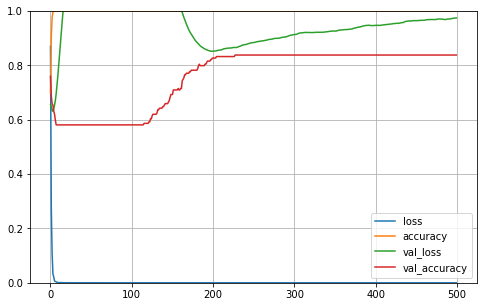

In [37]:
#NEXT Pipeline

from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense

from keras.callbacks import History


model = Sequential()
model.add(Dense(4000,activation="relu", input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(2000,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1000,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(500,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(250,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1,activation="sigmoid"))
model.summary()
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size=256, epochs=500)

model.evaluate(X_val,y_val)

from sklearn import  metrics
import matplotlib.pyplot as plt 

import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [32]:
metrics.accuracy_score(y_true= y_val, y_pred= (model.predict(X_val)  > 0.5))


0.8435754189944135

In [33]:
import numpy as np

X_test = preprocess_pipeline.transform(test_data)

predictions = model.predict(X_test) >0.5

prediction_5 = np.vstack([np.arange(len(train_data)+1,len(train_data)+len(predictions)+1,1),predictions.T]).T
prediction_5 = pd.DataFrame(prediction_5,columns=['PassengerId','Survived'])
prediction_5.to_csv(os.path.join("C:\\Users\\barak\\Documents\\GitHub\\Kaggle_Titanic_Competition\\Results",'MLP_1.csv'),index=False)


In [34]:
prediction_5

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [29]:
len(train_data)

891